[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers 

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.
 
## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

from typing_extensions import TypedDict
from typing import Annotated
from operator import add
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, RemoveMessage


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Default overwriting state

Let's use a `TypedDict` as our state schema.

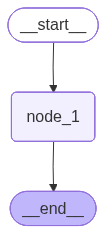

---Node 1---


{'foo': 2}

In [ ]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo": 1})


Let's look at the state update, `return {"foo": state['foo'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.
 
So, it will just overwrite the value of `foo` in `node_1`: 

```
return {"foo": state['foo'] + 1}
```
 
If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

In [3]:
# Branching nodes
def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)
graph = builder.compile()

from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo": 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We see a problem! 

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*. 

This is ambiguous for the graph! Which state should it keep? 

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

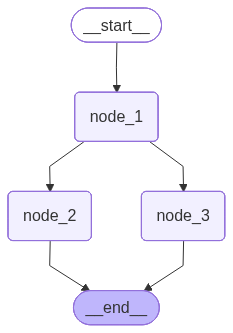

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

In [ ]:
class StateWithReducer(TypedDict):
    foo: Annotated[list[int], add]

def node_1_list(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

def node_2_list(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3_list(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

builder = StateGraph(StateWithReducer)
builder.add_node("node_1", node_1_list)
builder.add_node("node_2", node_2_list)
builder.add_node("node_3", node_3_list)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo": [1]})


Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list. 

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`. 

## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

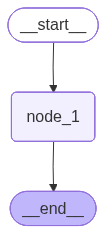

---Node 1---
{'foo': [2]}


In [ ]:
def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

def node_1_custom(state):
    print("---Node 1---")
    return {"foo": [2]}

builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1_custom)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

print(graph.invoke({"foo": None})) 


In `node_1`, we append the value 2.

Now, try with our custom reducer. We can see that no error is thrown.

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

* `MessagesState` has a built-in `messages` key 
* It also has a built-in `add_messages` reducer for this key

These two are equivalent. 

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [ ]:
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
]

new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages, new_message)


[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='7a494550-e9ff-4948-9c1d-bf4a223c48a7'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='abaf0d56-00eb-4ec5-96e1-b1895e65aafd'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='5f6f87ab-b369-468d-950e-40d092d5819b')]

Let's talk a bit more about usage of the `add_messages` reducer.

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [7]:
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
]

new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [8]:
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
add_messages(messages, delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.

MY CHANGES


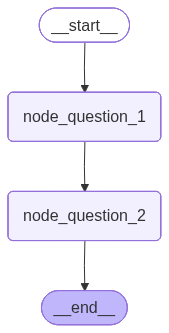

---Question 1 answered---
---Question 2 answered---


{'score': 15}

In [ ]:
def sum_scores(left: int | None, right: int | None) -> int:
    if left is None:
        left = 0
    if right is None:
        right = 0
    return left + right

class QuizState(TypedDict):
    score: Annotated[int, sum_scores]

def node_question_1(state):
    print("---Question 1 answered---")
    return {"score": 5}

def node_question_2(state):
    print("---Question 2 answered---")
    return {"score": 10}

builder = StateGraph(QuizState)
builder.add_node("node_question_1", node_question_1)
builder.add_node("node_question_2", node_question_2)
builder.add_edge(START, "node_question_1")
builder.add_edge("node_question_1", "node_question_2")
builder.add_edge("node_question_2", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"score": 0})
